In [1]:
import json
from pathlib import Path
import matplotlib as mpl
import tikzplotlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rich.progress import track
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.metrics import RocCurveDisplay, precision_recall_fscore_support, accuracy_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MaxAbsScaler

In [2]:
def parse_files(root_path):
    """
    Parse files and use pd.json_normalize to flatten the json.
    """
    files = root_path.joinpath("train-output-all-features").glob("**/*.json")
    results = pd.DataFrame()
    files = list(files)

    for file in track(
        files,
        description="Loading hyperparameters and "
        "performance data from file to DataFrame",
    ):
        with open(file) as f:
            data = json.load(f)
            original_target = root_path.joinpath(data["original_target"])
            original_dict = json.loads(Path(original_target).read_text())

            f1_scores = pd.json_normalize(data, "f1_scores")
            normalized_data = pd.json_normalize(original_dict)
            normalized_data = pd.concat(
                [normalized_data] * len(f1_scores), ignore_index=True
            )
            normalized_data["metrics.f1_score"] = f1_scores
            normalized_data["paths.model_path"] = data["model_path"]
            results = pd.concat([results, normalized_data])

    results = results.set_index(
        ["percentage", "model", "use_gradient", "use_ewma"]
    )
    results.columns = pd.MultiIndex.from_arrays(
        zip(*results.columns.str.split(".", expand=True))
    )
    results = results.sort_index(axis=1)
    results = results.drop(columns=['k_fold', 'preprocessing'])
    results = results.droplevel(0, axis=1)

    return results


data_flattened = parse_files(Path("./analysis/"))
data_flattened

Output()

C  alpha hidden_layer_sizes kernel   
percentage model use_gradient use_ewma                                         
4          SVM   True         False     1.0    NaN                NaN    rbf  \
                              False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
...                                     ...    ...                ...    ...   
19         LR    False        False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   

                                        learning_rate  max_depth   
percentage model use_gradient use_ewma                             
4          SVM   True         False               NaN        NaN  \
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
...                                               ...        ...   
19         LR    False        False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   

                                        n_estimators  f1_score   
percentage model use_gradient use_ewma                           
4          SVM   True         False              NaN  0.717391  \
                              False              NaN  0.708333   
                              False              NaN  0.717391   
                              False              NaN  0.691589   
                              False              NaN  0.736842   
...                                              ...       ...   
19         LR    False        False              NaN  0.627451   
                              False              NaN  0.576923   
                              False              NaN  0.685714   
                              False              NaN  0.416667   
                              False              NaN  0.478261   

                                                                               model_path  
percentage model use_gradient use_ewma                                                     
4          SVM   True         False     train-output-all-features/SVM_4_grad_no-ewma_3...  
                              False     train-output-all-features/SVM_4_grad_no-ewma_3...  
                              False     train-output-all-features/SVM_4_grad_no-ewma_3...  
                              False     train-output-all-features/SVM_4_grad_no-ewma_3...  
                              False     train-output-all-features/SVM_4_grad_no-ewma_3...  
...                                                                                   ...  
19         LR    False        False     train-output-all-features/LR_19_no-grad_no-ewm...  
                              False     train-output-all-features/LR_19_no-grad_no-ewm...  
                              False     train-output-all-features/LR_19_no-grad_no-ewm...  
                              False     train-output-all-features/LR_19_no-grad_no-ewm...  
                              False     train-output-all-features/LR_19_no-grad_no-ewm...  

[33540 rows x 9 columns]

In [3]:
# Remove any runs that included use_ewma or use_gradient
df = data_flattened.loc[(slice(None), slice(None), False, False), :]
df.index = df.index.droplevel([2, 3])
df = df.sort_values(by=['percentage', 'model'])
df

C  alpha hidden_layer_sizes  kernel  learning_rate   
percentage model                                                            
1          AdaBoost  NaN    NaN                NaN     NaN            0.1  \
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
...                  ...    ...                ...     ...            ...   
20         SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   

                     max_depth  n_estimators  f1_score   
percentage model                                         
1          AdaBoost        NaN          50.0  0.737705  \
           AdaBoost        NaN          50.0  0.710744   
           AdaBoost        NaN          50.0  0.861538   
           AdaBoost        NaN          50.0  0.761062   
           AdaBoost        NaN          50.0  0.794118   
...                        ...           ...       ...   
20         SVM             NaN           NaN  0.468085   
           SVM             NaN           NaN  0.625000   
           SVM             NaN           NaN  0.428571   
           SVM             NaN           NaN  0.489796   
           SVM             NaN           NaN  0.541667   

                                                            model_path  
percentage model                                                        
1          AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
           AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
           AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
           AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
           AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
...                                                                ...  
20         SVM       train-output-all-features/SVM_20_no-grad_no-ew...  
           SVM       train-output-all-features/SVM_20_no-grad_no-ew...  
           SVM       train-output-all-features/SVM_20_no-grad_no-ew...  
           SVM       train-output-all-features/SVM_20_no-grad_no-ew...  
           SVM       train-output-all-features/SVM_20_no-grad_no-ew...  

[8600 rows x 9 columns]

In [4]:
def float_or_list_to_tuple(x):
    if isinstance(x, list):
        return tuple(x)
    return x

df["hidden_layer_sizes"] = df['hidden_layer_sizes'].apply(float_or_list_to_tuple)

In [5]:
group = df.groupby(['percentage', 'model', 'C', 'hidden_layer_sizes', 'kernel', 'learning_rate', 'max_depth', 'n_estimators', 'alpha'], dropna=False)
summary = group['f1_score'].agg(['mean', 'std'])

idx = summary.groupby(['percentage', 'model']).idxmax()

best_hyperparams = summary.loc[idx['mean'], :]
best_per_percentage = best_hyperparams.groupby('percentage')['mean'].idxmax()
selected_percentages = best_hyperparams[best_hyperparams.index.get_level_values('percentage').isin([1]) & best_hyperparams.index.get_level_values('model').isin(['RF'])]
models_to_test = selected_percentages.droplevel(['C', 'hidden_layer_sizes', 'kernel', 'learning_rate', 'alpha'])
models_to_test


mean       std
percentage model max_depth n_estimators                    
1          RF    10.0      200.0         0.902874  0.030793

In [6]:
random_state = 42
classifiers = {}
for percentage, model, max_depth, n_estimators in models_to_test.index:
    if np.isnan(max_depth):
        max_depth = None
    else:
        max_depth = int(max_depth)
    if model != 'DT':
        n_estimators = int(n_estimators)
    if model == 'ET':
        classifiers[(percentage, model)] = ExtraTreesClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state, class_weight='balanced')
    elif model == 'RF':
        classifiers[(percentage, model)] = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state, class_weight='balanced_subsample')
    elif model == 'DT':
        classifiers[(percentage, model)] = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state, class_weight='balanced')
    classifiers[(percentage, 'Dum')] = DummyClassifier(strategy='stratified', random_state=random_state)
classifiers

{(1,
  'RF'): RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                        n_estimators=200, random_state=42),
 (1, 'Dum'): DummyClassifier(random_state=42, strategy='stratified')}

In [57]:
import pickle

def preprocess(dataframe, scaler=None):
    result, mzn = dataframe.drop(columns=['mzn', 'dzn'], axis=1), dataframe['mzn']

    # Drop any columns that contain the text 'ewma' or 'gradient'
    result = result.drop(columns=result.columns[result.columns.str.contains('ewma|gradient')], axis=1)

    
    # result = result.drop(result.columns[result.nunique() == 1], axis=1)

    if scaler is None:
        result = result.drop(result.columns[result.nunique() == 1], axis=1)
        scaler = MaxAbsScaler().fit(result)
    else:
        # Drop constant columns except those in scaler.feature_names_in_
        constant_columns = result.columns[result.nunique() == 1]
        features_in = scaler.feature_names_in_
        columns_to_drop = constant_columns.difference(features_in)
        result = result.drop(columns=columns_to_drop, axis=1)
        
        
    result = pd.DataFrame(scaler.transform(result), columns=result.columns, index=result.index)

    result['mzn'] = mzn

    return result, scaler

def drop_easy_problems(dataset):
    problems_left_at_10 = dataset[19][['mzn', 'dzn']]
    hash_of_problems_left_at_10 = problems_left_at_10['mzn'] + problems_left_at_10['dzn']

    new_dataset = {}
    for half_percentage in dataset.keys():
        features = dataset[half_percentage]
        new_dataset[half_percentage] = []
        new_features = []
        # remove rows in features whose hash is not in hash_of_problems_left_at_20
        for _, row in features.iterrows():
            hash_of_row = row['mzn'] + row['dzn']
            if hash_of_row in hash_of_problems_left_at_10.values:
                new_features.append(row)
        new_dataset[half_percentage] = pd.DataFrame(new_features)
        
    return new_dataset


scalers = {}

train_pkl = Path('./analysis/rerun_with_all_features_train.pkl')
test_pickle = Path('./analysis/rerun_with_all_features_test.pkl')

with open(train_pkl, 'rb') as f:
    train_features_at_percentage = pickle.load(f)

with open(test_pickle, 'rb') as f:
    test_features_at_percentage = pickle.load(f)

In [58]:
#train_features_at_percentage
#print columns of the dataframe
print(train_features_at_percentage[1].shape)
print(train_features_at_percentage[1].columns)

(1303, 39)
Index(['conflicts', 'ewma_conflicts', 'decisions', 'search_iterations',
       'opennodes', 'ewma_opennodes', 'vars', 'back_jumps', 'ewma_back_jumps',
       'solutions', 'total_time', 'search_time', 'intVars', 'propagations',
       'sat_propagations', 'ewma_propagations', 'propagators', 'boolVars',
       'learnt', 'bin', 'tern', 'long', 'peak_depth', 'decision_level_engine',
       'ewma_decision_level_engine', 'decision_level_treesize', 'clause_mem',
       'prop_mem', 'fracFailUnassn', 'fracOpenVisit', 'fracBoolVars',
       'fracPropVars', 'frac_unassigned', 'fracLongClauses', 'freqBackjumps',
       'mzn', 'dzn', 'solved_within_time_limit', 'has_gradients'],
      dtype='object')


# EWMA & Gradient Ablation

In [54]:
train_features_at_percentage[5]

conflicts  ewma_conflicts  decisions  search_iterations  opennodes   
644       40975         40956.0      42625              83601     684726  \
45       187439        187420.0     205661             393101      32078   
1026       6444          6425.0      21553              15795      69348   
261       83861         83842.0     859836             906410      10477   
797       44923         44904.0      59135              46357     128292   
...         ...             ...        ...                ...        ...   
318       64522         64503.0      67878             132401    3089563   
1299      93146         93127.0      98854             192001     680066   
1086     450690        450671.0     450702             901393        170   
1369      54793         54774.0      61211              29294      88541   
1489      33488         33469.0      36012              69501    1593039   

      ewma_opennodes     vars  back_jumps  ewma_back_jumps  solutions  ...   
644        684727.19   684838        1537             0.00          0  ...  \
45          32079.01    32108       18191             0.04          0  ...   
1026        69348.07    72312        2966             0.00          3  ...   
261         10471.98    10693      774595             4.16          3  ...   
797        128262.81   128307       11728             0.28         42  ...   
...              ...      ...         ...              ...        ...  ...   
318       3089563.50  3090204        2713             0.01          0  ...   
1299       680065.69   680524        5248             0.01          0  ...   
1086          169.47      180           0             0.00          0  ...   
1369        88534.16    88557        3641             0.07         95  ...   
1489      1593040.00  1593764        1797             0.00          0  ...   

      decision_level_engine_gradient  ewma_decision_level_engine_gradient   
644                              0.0                                  0.0  \
45                          432000.0                              53280.0   
1026                             0.0                                  0.0   
261                        -288000.0                             293760.0   
797                       -5040000.0                           -3893760.0   
...                              ...                                  ...   
318                        -144000.0                            -239040.0   
1299                        144000.0                             -43200.0   
1086                             0.0                             272160.0   
1369                       -288000.0                            -329760.0   
1489                       -144000.0                            -244800.0   

      decision_level_treesize_gradient  clause_mem_gradient   
644                       0.000000e+00                  0.0  \
45                        4.377600e+09                  0.0   
1026                      2.160000e+08                  0.0   
261                       2.070720e+10                  0.0   
797                       2.491200e+09                  0.0   
...                                ...                  ...   
318                       3.585600e+09                  0.0   
1299                      3.744000e+09                  0.0   
1086                      2.165731e+10                  0.0   
1369                      2.879856e+09                  0.0   
1489                      3.081600e+09                  0.0   

      prop_mem_gradient  fracOpenVisit_gradient  fracBoolVars_gradient   
644                 0.0                0.000000               0.000000  \
45                  0.0                0.000000               0.000000   
1026                0.0                0.000000               0.000000   
261                 0.0              -30.064874               2.011318   
797                 0.0              -41.415364             159.234942   
...                 ...       

## Train preprocessing

In [78]:
#Train dataset full features
train_5perc= train_features_at_percentage[5].drop(columns=['mzn', 'dzn'], axis=1)
train_5perc_X= train_5perc.drop(columns=['solved_within_time_limit'], axis=1)
train_5perc_y= train_5perc['solved_within_time_limit']

#Train dataset no gradient and no ewma
train_no_grad_no_ewma = train_5perc.drop(columns=train_5perc.columns[train_5perc.columns.str.contains('ewma|gradient')], axis=1)
train_no_grad_no_ewma_X= train_no_grad_no_ewma.drop(columns=['solved_within_time_limit'], axis=1)
train_no_grad_no_ewma_y= train_no_grad_no_ewma['solved_within_time_limit']


#Train dataset only gradient and ewma and solved_within_time_limit
train_only_grad_ewma = train_5perc[train_5perc.columns[train_5perc.columns.str.contains('ewma|gradient|solved_within_time_limit')]]
train_only_grad_ewma_X= train_only_grad_ewma.drop(columns=['solved_within_time_limit'], axis=1)
train_only_grad_ewma_y= train_only_grad_ewma['solved_within_time_limit']

## Test preprocessing

In [79]:
#Test dataset full features
test_5perc= test_features_at_percentage[5].drop(columns=['mzn', 'dzn'], axis=1)
test_5perc_X= test_5perc.drop(columns=['solved_within_time_limit'], axis=1)
test_5perc_y= test_5perc['solved_within_time_limit']

#Test dataset no gradient and no ewma
test_no_grad_no_ewma = test_5perc.drop(columns=test_5perc.columns[test_5perc.columns.str.contains('ewma|gradient')], axis=1)
test_no_grad_no_ewma_X= test_no_grad_no_ewma.drop(columns=['solved_within_time_limit'], axis=1)
test_no_grad_no_ewma_y= test_no_grad_no_ewma['solved_within_time_limit']

#Test dataset only gradient and ewma and solved_within_time_limit
test_only_grad_ewma = test_5perc[test_5perc.columns[test_5perc.columns.str.contains('ewma|gradient|solved_within_time_limit')]]
test_only_grad_ewma_X= test_only_grad_ewma.drop(columns=['solved_within_time_limit'], axis=1)
test_only_grad_ewma_y= test_only_grad_ewma['solved_within_time_limit']

In [84]:
#Sanity check because of the error below
print(train_5perc_X.keys()==test_5perc_X.keys())
print(train_no_grad_no_ewma_X.keys()==test_no_grad_no_ewma_X.keys())
print(train_only_grad_ewma_X.keys()==test_only_grad_ewma_X.keys())

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


In [90]:
#Attempt 1 to fix error below...

train_cols = set(train_5perc_X.columns)
test_cols = set(test_5perc_X.columns)

not_common_cols = train_cols.symmetric_difference(test_cols)
not_common_cols


train_5perc_full_X = train_5perc_X.drop(columns=not_common_cols, errors='ignore')
test_5perc_X = test_5perc_X.drop(columns=not_common_cols, errors='ignore')

In [93]:
#Attempt 2 to fix error below...
test_5perc_X = test_5perc_X[train_5perc_X.columns]


In [94]:
RF=RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42, class_weight='balanced_subsample')

RF_5perc = RF.fit(train_5perc_X, train_5perc_y)
RF_no_grad_no_ewma = RF.fit(train_no_grad_no_ewma_X, train_no_grad_no_ewma_y)
RF_only_grad_ewma = RF.fit(train_only_grad_ewma_X, train_only_grad_ewma_y)


predicted_y = RF_5perc.predict(test_5perc_X)
prec, rec, score, support = precision_recall_fscore_support(test_5perc_y, predicted_y, average='binary', pos_label=False)

predicted_y = RF_no_grad_no_ewma.predict(test_5perc_X)
prec, rec, score, support = precision_recall_fscore_support(test_no_grad_no_ewma_y, predicted_y, average='binary', pos_label=False)

predicted_y = RF_only_grad_ewma.predict(test_5perc_X)
prec, rec, score, support = precision_recall_fscore_support(test_only_grad_ewma_y, predicted_y, average='binary', pos_label=False)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- back_jumps
- bin
- boolVars
- clause_mem
- conflicts
- ...


# Number of features Ablation

To Determine the chosen features, we are using the ranking from feature importance metric

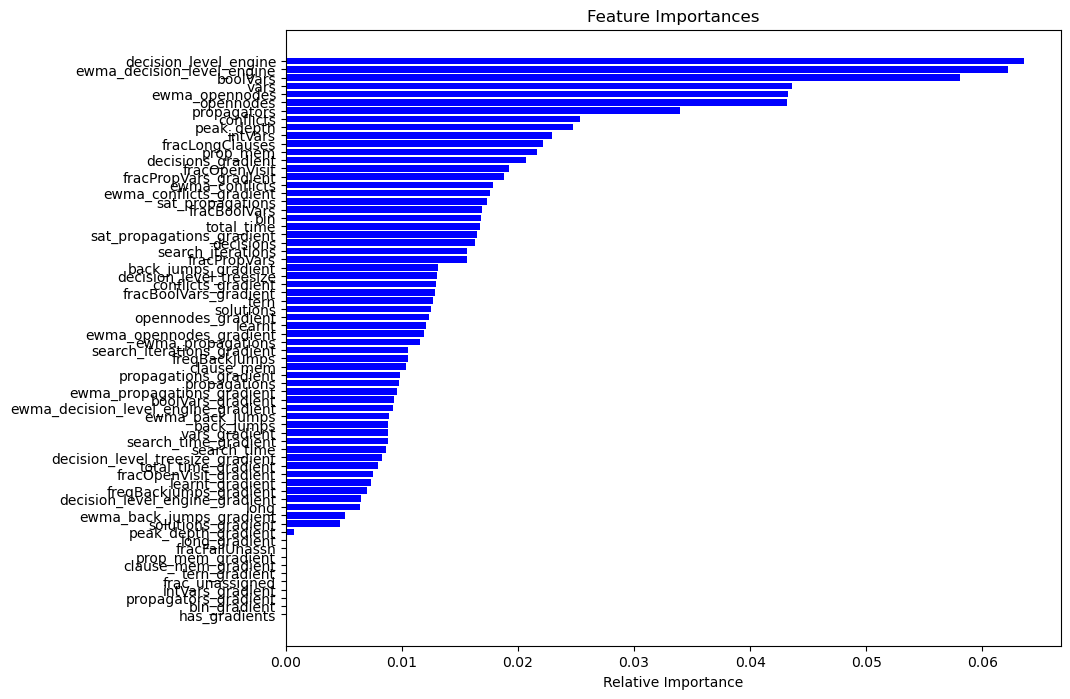

In [95]:
# Train the model (already done in your case)
RF = RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42, class_weight='balanced_subsample')
RF.fit(train_5perc_X, train_5perc_y)

# Extract feature importances
importances = RF.feature_importances_
features = train_5perc_X.columns
indices = np.argsort(importances)

# Plotting
plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [98]:
indices = np.argsort(importances)[::-1]
sorted_features = train_5perc_X.columns[indices]

from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Store f1 scores for each feature count
f1_scores = []

# Incrementally add features
for i in range(1, len(sorted_features) + 1):
    # Select the top-i features
    selected_features = sorted_features[:i]
    train_subset_X = train_5perc_X[selected_features]

    # Split the data for evaluation
    X_train, X_test, y_train, y_test = train_test_split(train_subset_X, train_5perc_y, test_size=0.2, random_state=42)
    
    # Train and evaluate the model
    RF_subset = RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42, class_weight='balanced_subsample')
    RF_subset.fit(X_train, y_train)
    y_pred = RF_subset.predict(X_test)
    
    # Compute the f1 score
    prec, rec, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    f1_scores.append(f1_score)



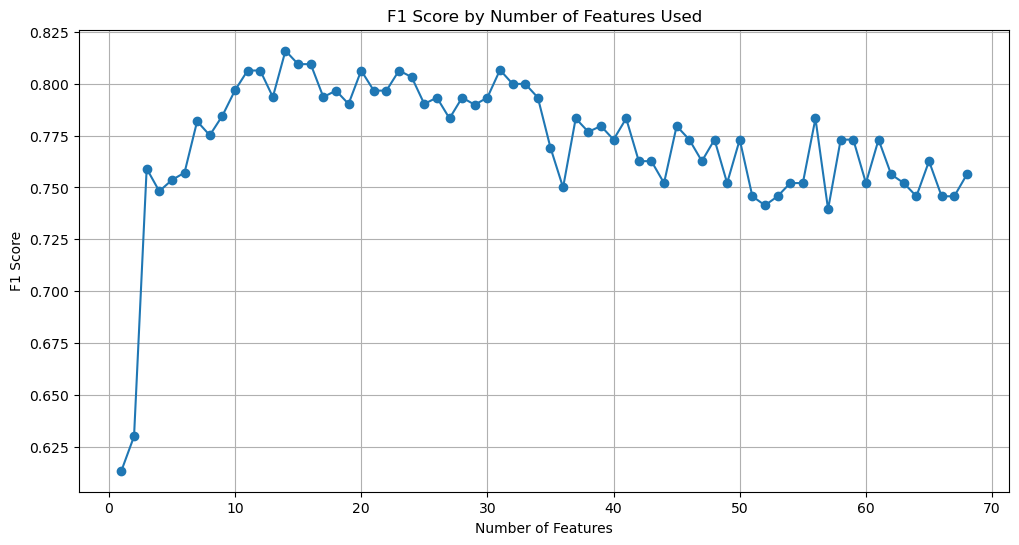

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(sorted_features) + 1), f1_scores, marker='o')
plt.title('F1 Score by Number of Features Used')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


# Problem ablation

In [11]:
problem_types_labels=train_features_at_percentage[1]['mzn'].unique()
#print(problem_types_labels[1])
#for i in range(len(problem_types_labels)):
    #print(problem_types_labels[i])

# Initialize dictionaries to store the results
include_specific_problem_types = {}
exclude_specific_problem_types = {}

for problem_type in problem_types_labels:
    # Creating a dictionary for including only specific problem type
    include_specific_problem_types[problem_type] = {
        k: v[v['mzn'] == problem_type] for k, v in train_features_at_percentage.items()
    }

    # Creating a dictionary for excluding specific problem type
    exclude_specific_problem_types[problem_type] = {
        k: v[v['mzn'] != problem_type] for k, v in train_features_at_percentage.items()
    }

In [12]:
print(exclude_specific_problem_types['2DLevelPacking.mzn'])

{1:       conflicts  ewma_conflicts  decisions  search_iterations  opennodes   
1171       8803          8784.0      11197              20001    3088703  \
638       91874         91855.0     110223             201798       1703   
931       11623         11604.0     192877             204501     169010   
258       78777         78758.0      81520                 20      75046   
1182      37362         37343.0      98212               9372      37725   
...         ...             ...        ...                ...        ...   
1173       1402          1383.0       4082                584    6738231   
714      100714        100695.0     111385             212100      25323   
699       89041         89022.0      91142              76988      19205   
900       49573         49554.0      56626             105054      19979   
583        3725          3706.0     221474              90036     441131   

      ewma_opennodes     vars  back_jumps  ewma_back_jumps  solutions  ...   
1171 

In [13]:
print(train_features_at_percentage[5].shape)
print(include_specific_problem_types['2DLevelPacking.mzn'][5].shape)
print(exclude_specific_problem_types['2DLevelPacking.mzn'][5].shape)

(1068, 71)
(31, 71)
(1037, 71)


In [14]:
random_state = 42
classifiers = {}

# Assuming problem_types_labels is defined as before
for problem_type in problem_types_labels:
    for percentage, model, max_depth, n_estimators in models_to_test.index:
        if np.isnan(max_depth):
            max_depth = None
        else:
            max_depth = int(max_depth)
        
        if model != 'DT':
            n_estimators = int(n_estimators)
        
        if model == 'ET':
            classifiers[(problem_type, percentage, model)] = ExtraTreesClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state, class_weight='balanced')
        elif model == 'RF':
            classifiers[(problem_type, percentage, model)] = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state, class_weight='balanced_subsample')
        elif model == 'DT':
            classifiers[(problem_type, percentage, model)] = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state, class_weight='balanced')

        # Assuming you want to keep a dummy classifier for each combination
        #classifiers[(problem_type, percentage, 'Dum')] = DummyClassifier(strategy='stratified', random_state=random_state)

# Print out the keys to verify
print("Classifier keys:", classifiers.keys())


Classifier keys: dict_keys([('2DPacking.mzn', 1, 'RF'), ('still_life_free.mzn', 1, 'RF'), ('wwtpp.mzn', 1, 'RF'), ('city-position.mzn', 1, 'RF'), ('ProjectPlannertest_16_7.mzn', 1, 'RF'), ('mrcpsp.mzn', 1, 'RF'), ('nsp_1.mzn', 1, 'RF'), ('cars.mzn', 1, 'RF'), ('rect_packing.mzn', 1, 'RF'), ('cvrp.mzn', 1, 'RF'), ('pc.mzn', 1, 'RF'), ('golfers2.mzn', 1, 'RF'), ('8div-n59k10.mzn', 1, 'RF'), ('proteindesign121pgb11p9.mzn', 1, 'RF'), ('atsp.mzn', 1, 'RF'), ('jobshop.mzn', 1, 'RF'), ('fastfood.mzn', 1, 'RF'), ('amaze2.mzn', 1, 'RF'), ('sorrell4.mzn', 1, 'RF'), ('celar.mzn', 1, 'RF'), ('amaze.mzn', 1, 'RF'), ('wcsp.mzn', 1, 'RF'), ('pattern_set_mining_k1.mzn', 1, 'RF'), ('rcpsp.mzn', 1, 'RF'), ('2DLevelPacking.mzn', 1, 'RF'), ('vrp.mzn', 1, 'RF'), ('nsp_2.mzn', 1, 'RF'), ('still-life.mzn', 1, 'RF'), ('mapf.mzn', 1, 'RF'), ('tdtsp.mzn', 1, 'RF'), ('golfers3.mzn', 1, 'RF'), ('30n20b8.mzn', 1, 'RF'), ('crossword_opt.mzn', 1, 'RF'), ('no-ip-64999.mzn', 1, 'RF'), ('opd.mzn', 1, 'RF'), ('vpphard.m

In [15]:
# Loop through each problem type
for problem_type in problem_types_labels:
    # Loop through each classifier key
    for key in classifiers:
        # Unpack the key into problem type, percentage, and model
        key_problem_type, percentage, model = key

        # Check if the current classifier key matches the problem type being iterated
        if key_problem_type == problem_type:
            print(f"Training {model} for problem type '{problem_type}' at {percentage}% (excluding problem type)")

            # Preprocess excluding the specific problem type
            df_excluded, scaler_excluded = preprocess(exclude_specific_problem_types[problem_type][percentage])
            scalers[(problem_type, percentage, model, 'exclude')] = scaler_excluded
            df_excluded = df_excluded.drop(columns=['mzn'], axis=1)
            any_nan_excluded = df_excluded.isna().any().any()
            
            if any_nan_excluded:
                print("The NaN values are in the following columns:")
                print(df_excluded.columns[df_excluded.isna().any()])
            else:
                train_X_excluded, train_y_excluded = df_excluded.drop(columns=['solved_within_time_limit']), df_excluded['solved_within_time_limit']
                print(train_y_excluded.value_counts(normalize=False))
                classifiers[key].fit(train_X_excluded, train_y_excluded)


Training RF for problem type '2DPacking.mzn' at 1% (excluding problem type)
solved_within_time_limit
1.0    577
0.0    473
Name: count, dtype: int64
Training RF for problem type 'still_life_free.mzn' at 1% (excluding problem type)
solved_within_time_limit
0.0    696
1.0    606
Name: count, dtype: int64
Training RF for problem type 'wwtpp.mzn' at 1% (excluding problem type)
solved_within_time_limit
0.0    652
1.0    556
Name: count, dtype: int64
Training RF for problem type 'city-position.mzn' at 1% (excluding problem type)
solved_within_time_limit
0.0    692
1.0    607
Name: count, dtype: int64
Training RF for problem type 'ProjectPlannertest_16_7.mzn' at 1% (excluding problem type)
solved_within_time_limit
0.0    696
1.0    606
Name: count, dtype: int64
Training RF for problem type 'mrcpsp.mzn' at 1% (excluding problem type)
solved_within_time_limit
0.0    694
1.0    528
Name: count, dtype: int64
Training RF for problem type 'nsp_1.mzn' at 1% (excluding problem type)
solved_within_tim

KeyboardInterrupt: 

In [64]:
# Experiment 1 for REVIEWER 1 -> drop 2DPacking and wwtpp from training set
# drop all where mzn == "2DPacking.mzn" or "wwtpp.mzn"
#only_2DPacking_and_wwtpp = {k: v[v['mzn'].isin(['2DPacking.mzn', 'wwtpp.mzn'])] for k, v in train_features_at_percentage.items()}
#train_features_at_percentage = {k: v[~v['mzn'].isin(['2DPacking.mzn', 'wwtpp.mzn'])] for k, v in train_features_at_percentage.items()}

# Experiment 2 for REVIEWER 1 -> drop problem types iteratively from training set
# shuffle the dropped column
# Initialize dictionaries to store the results
include_specific_problem_types = {}
exclude_specific_problem_types = {}

for problem_type in problem_types_labels:
    # Creating a dictionary for including only specific problem type
    include_specific_problem_types[problem_type] = {
        k: v[v['mzn'] == problem_type] for k, v in train_features_at_percentage.items()
    }

    # Creating a dictionary for excluding specific problem type
    exclude_specific_problem_types[problem_type] = {
        k: v[v['mzn'] != problem_type] for k, v in train_features_at_percentage.items()
    }
    


# Experiment for REVIEWER 3
# train_features_at_percentage = drop_easy_problems(train_features_at_percentage)


for percentage, model in classifiers:
    print(f"Training {model} at {percentage}%")
    df, scaler = preprocess(train_features_at_percentage[percentage])
    scalers[(percentage, model)] = scaler
    df = df.drop(columns=['mzn'], axis=1)
    any_nan = df.isna().any().any()
    
    if any_nan:
        print("The NaN values are in the following columns:")
        print(df.columns[df.isna().any()])
    else:
        train_X, train_y = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']
        print(train_y.value_counts(normalize=False))
        classifiers[(percentage, model)].fit(train_X, train_y)

Training DT at 1%
solved_within_time_limit
1.0    526
0.0    429
Name: count, dtype: int64
Training Dum at 1%
solved_within_time_limit
1.0    526
0.0    429
Name: count, dtype: int64
Training ET at 1%
solved_within_time_limit
1.0    526
0.0    429
Name: count, dtype: int64
Training RF at 1%
solved_within_time_limit
1.0    526
0.0    429
Name: count, dtype: int64
Training DT at 5%
solved_within_time_limit
0.0    437
1.0    330
Name: count, dtype: int64
Training Dum at 5%
solved_within_time_limit
0.0    437
1.0    330
Name: count, dtype: int64
Training ET at 5%
solved_within_time_limit
0.0    437
1.0    330
Name: count, dtype: int64
Training RF at 5%
solved_within_time_limit
0.0    437
1.0    330
Name: count, dtype: int64
Training DT at 10%
solved_within_time_limit
0.0    426
1.0    225
Name: count, dtype: int64
Training Dum at 10%
solved_within_time_limit
0.0    426
1.0    225
Name: count, dtype: int64
Training ET at 10%
solved_within_time_limit
0.0    426
1.0    225
Name: count, dtype:

In [16]:
train_features_at_percentage[1].columns


Index(['conflicts', 'ewma_conflicts', 'decisions', 'search_iterations',
       'opennodes', 'ewma_opennodes', 'vars', 'back_jumps', 'ewma_back_jumps',
       'solutions', 'total_time', 'search_time', 'intVars', 'propagations',
       'sat_propagations', 'ewma_propagations', 'propagators', 'boolVars',
       'learnt', 'bin', 'tern', 'long', 'peak_depth', 'decision_level_engine',
       'ewma_decision_level_engine', 'decision_level_treesize', 'clause_mem',
       'prop_mem', 'fracFailUnassn', 'fracOpenVisit', 'fracBoolVars',
       'fracPropVars', 'frac_unassigned', 'fracLongClauses', 'freqBackjumps',
       'mzn', 'dzn', 'solved_within_time_limit', 'has_gradients'],
      dtype='object')

In [19]:
describe_features = pd.DataFrame({'feature': preprocess(train_features_at_percentage[1])[0].drop(['mzn', 'solved_within_time_limit'], axis=1).columns})
describe_features['description'] = [
    "Number of conflicts",
    "Number of decisions made/nodes",
    "Number of search iterations completed",
    "??? (number of assigned nodes or variables)",
    "Number of variables",
    "Number of backjumps",
    "Number of solutions found",
    "Total time spent",
    "Time spent searching",
    "Number of integer variables",
    "Number of propagations",
    "Number of SAT propagations",
    "Number of propagators",
    "Number of boolean variables",
    "Number of learnt clauses",
    "Number of binary clauses",
    "Number of ternary clauses",
    "Number of clauses longer than 3",
    "The maximum decision level reached",
    "Current decision level of the engine",
    "Size of the tree of the decision level",
    "Amount of memory used by clauses",
    "Amount of memory used by propagators",
    "Ratio of failures/conflicts to unassigned variables",
    "Ratio of visited nodes to open nodes",
    "Fraction of variables that are boolean",
    "Ratio of propagations to variables",
    "Fraction of clauses that are longer than 3",
    "How often the engine backtracks (backjumps / total search time)",
]
describe_features['translated'] = [
    False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, True
]
describe_features

feature   
0                 conflicts  \
1                 decisions   
2         search_iterations   
3                 opennodes   
4                      vars   
5                back_jumps   
6                 solutions   
7                total_time   
8               search_time   
9                   intVars   
10             propagations   
11         sat_propagations   
12              propagators   
13                 boolVars   
14                   learnt   
15                      bin   
16                     tern   
17                     long   
18               peak_depth   
19    decision_level_engine   
20  decision_level_treesize   
21               clause_mem   
22                 prop_mem   
23           fracFailUnassn   
24            fracOpenVisit   
25             fracBoolVars   
26             fracPropVars   
27          fracLongClauses   
28            freqBackjumps   

                                          description  translated  
0                                 Number of conflicts       False  
1                      Number of decisions made/nodes       False  
2               Number of search iterations completed       False  
3         ??? (number of assigned nodes or variables)       False  
4                                 Number of variables       False  
5                                 Number of backjumps       False  
6                           Number of solutions found       False  
7                                    Total time spent       False  
8                                Time spent searching       False  
9                         Number of integer variables       False  
10                             Number of propagations       False  
11                         Number of SAT propagations       False  
12                              Number of propagators       False  
13                        Number of boolean variables       False  
14                           Number of learnt clauses       False  
15                           Number of binary clauses       False  
16                          Number of ternary clauses       False  
17                    Number of clauses longer than 3       False  
18                 The maximum decision level reached       False  
19               Current decision level of the engine       False  
20             Size of the tree of the decision level       False  
21                   Amount of memory used by clauses       False  
22               Amount of memory used by propagators       False  
23  Ratio of failures/conflicts to unassigned vari...        True  
24               Ratio of visited nodes to open nodes        True  
25             Fraction of variables that are boolean       False  
26                 Ratio of propagations to variables       False  
27         Fraction of clauses that are longer than 3       False  
28  How often the engine backtracks (backjumps / t...        True

In [20]:
describe_features.columns.str.capitalize()

Index(['Feature', 'Description', 'Translated'], dtype='object')

In [44]:
test_features_at_percentage[1]['mzn'].unique()


array(['2DPacking.mzn', 'still_life_free.mzn', 'wwtpp.mzn',
       'city-position.mzn', 'ProjectPlannertest_16_7.mzn', 'mrcpsp.mzn',
       'nsp_1.mzn', 'cars.mzn', 'rect_packing.mzn', 'cvrp.mzn', 'pc.mzn',
       'golfers2.mzn', '8div-n59k10.mzn', 'proteindesign121pgb11p9.mzn',
       'atsp.mzn', 'jobshop.mzn', 'fastfood.mzn', 'amaze2.mzn',
       'sorrell4.mzn', 'celar.mzn', 'amaze.mzn', 'wcsp.mzn',
       'pattern_set_mining_k1.mzn', 'rcpsp.mzn', '2DLevelPacking.mzn',
       'vrp.mzn', 'nsp_2.mzn', 'still-life.mzn', 'mapf.mzn', 'tdtsp.mzn',
       'golfers3.mzn', '30n20b8.mzn', 'crossword_opt.mzn',
       'no-ip-64999.mzn', 'opd.mzn', 'vpphard.mzn', 'radiation.mzn',
       'model.mzn', 'supportcase18.mzn', 'nu120-pr12.mzn', 'air04.mzn',
       'rect_packing_opt.mzn', 'cutstock.mzn', 'ship-schedule.mip.mzn',
       'quasigroup7.mzn', 'road_naive.mzn', 'golomb.mzn',
       'cargo_coarsePiles.mzn', 'sugiyama2-mznchallenge2010.mzn',
       'league.mzn', 'skill_allocation_only.mzn', 'par

In [47]:
test_pickle = Path('./analysis/rerun_with_all_features_test.pkl')

with open(test_pickle, 'rb') as f:
    test_features_at_percentage = pickle.load(f)

# Initialize a list to store the scores
scores = []

# Loop through each problem type
for problem_type in problem_types_labels:
    # Loop through each percentage
    for percentage in test_features_at_percentage:
        # Filter test data for the current problem type
        problem_type_data = test_features_at_percentage[percentage][test_features_at_percentage[percentage]['mzn'] == problem_type]

        # Check if problem type exists in test_features_at_percentage
        if not problem_type_data.empty:
            print('true')
            # Concatenate only if problem type exists in test_features_at_percentage
            test_features_at_percentage[percentage] = pd.concat([problem_type_data, include_specific_problem_types[problem_type][percentage]])
        else:
            test_features_at_percentage[percentage] = include_specific_problem_types[problem_type][percentage]

        # Testing the classifiers
        for key in classifiers:
            # Unpack the key into problem type, percentage, and model
            key_problem_type, percentage, model = key

            # Ensure classifier is for the current problem type
            if key_problem_type == problem_type:
                scaler = scalers[(problem_type, percentage, model, 'exclude')]
                df, _ = preprocess(test_features_at_percentage[percentage], scaler)
                print(df.shape)
                df = df.drop(columns=['mzn'], axis=1)
                test_X, test_y = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']

                # Get predictions and compute F1 score
                print(key)
                predicted_y = classifiers[key].predict(test_X)
                prec, rec, score, support = precision_recall_fscore_support(test_y, predicted_y, average='binary', pos_label=False)

                # Store the scores
                scores.append([problem_type, percentage, model, score])

# Printing the F1 scores for each problem instance
for score in scores:
    print(f"Problem Type: {score[0]}, Percentage: {score[1]}%, Model: {score[2]}, F1 Score: {score[3]:.2f}")


true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1, 'RF')
true
(272, 31)
('2DPacking.mzn', 1

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')
(1, 31)
('still_life_free.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)
('wwtpp.mzn', 1, 'RF')
(95, 31)

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(4, 31)
('city-position.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(81, 31)
('mrcpsp.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')
(14, 31)
('nsp_1.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(12, 31)
('cars.mzn', 1, 'RF')
(12, 31)
('cars.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(6, 31)
('rect_packing.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('cvrp.mzn', 1, 'RF')
(5, 31)
('

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(11, 31)
('pc.mzn', 1, 'RF')
(11, 31)
('pc.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(2, 31)
('golfers2.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(1, 31)
('8div-n59k10.mzn', 1, 'RF')
(

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')
(17, 31)
('fastfood.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(17, 31)
('fastfood.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)
('amaze2.mzn', 1, 'RF')
(15, 31)

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('amaze.mzn', 1, 'RF')
(3, 31)
('amaze.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')
(6, 31)
('wcsp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(6, 31)
('wcsp.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
('pattern_set_mining_k1.mzn', 1, 'RF')
(11, 31)
(

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(14, 31)
('nsp_2.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')
(3, 31)
('still-life.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('mapf.mzn', 1, 'RF')
(7, 31)
('

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('30n20b8.mzn', 1, 'RF')
(1, 31)
('30n20b8.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF')
(6, 31)
('crossword_opt.mzn', 1, 'RF'

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(1, 31)
('no-ip-64999.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')
(5, 31)
('opd.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(5, 31)
('opd.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpphard.mzn', 1, 'RF')
(1, 31)
('vpph

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')
(3, 31)
('radiation.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)
('model.mzn', 1, 'RF')
(10, 31)

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('quasigroup7.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn', 1, 'RF')
(3, 31)
('road_naive.mzn',

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('golomb.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('cargo_coarsePiles.mzn', 1, 'RF')
(2, 31)
('ca

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(3, 31)
('sugiyama2-mznchallenge2010.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(4, 31)
('league.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('skill_allocation_only.mzn', 1, 'RF')
(3, 31)
('ski

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(5, 31)
('parity-learning.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2-z12-s8.mzn', 1, 'RF')
(1, 31)
('opm2

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(2, 31)
('ship-schedule.cp.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('nw04.mzn', 1, 'RF')
(1, 31)
('

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')
(2, 31)
('tcgc2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)
('train.mzn', 1, 'RF')
(11, 31)

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')
(1, 31)
('k1mushroom.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('full.mzn', 1, 'RF')
(4, 31)
('

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')
(5, 31)
('black-hole.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1, 'RF')
(1, 31)
('connect__0086_02.mzn', 1

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(2, 31)
('evilshop.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)
('mario.mzn', 1, 'RF')
(8, 31)


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(1, 31)
('sugiyama2.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('p1f-pjs.mzn', 1, 'RF')
(5, 31)
('

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(1, 31)
('bacp-28.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(6, 31)
('dcmst.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(8, 31)
('market_split.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)
('tp7_12.mzn', 1, 'RF')
(1, 31)


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('piperout-d20.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)
('accap.mzn', 1, 'RF')
(1, 31)


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(3, 31)
('CostasArray.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(1, 31)
('fm3_0.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(8, 31)
('handball.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)
('queens.mzn', 1, 'RF')
(1, 31)


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_7.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')
(1, 31)
('pw-myciel4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largecumulative.mzn', 1, 'RF')
(6, 31)
('largec

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(3, 31)
('vrplc_service.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)
('map10.mzn', 1, 'RF')
(1, 31)


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('talent_scheduling.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.mzn', 1, 'RF')
(1, 31)
('connect__0018.m

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(4, 31)
('steelmillslab.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1, 'RF')
(1, 31)
('gfd-schedulen180f7d50m30k18.mzn', 1,

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(3, 31)
('seat-moving.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('mknapsack_global.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('mknapsack_global.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122trx11p8.mzn', 1, 'RF')
(1, 31)
('proteindesign122t

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(3, 31)
('sudoku_opt.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(1, 31)
('cvs16r70-62.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1, 'RF')
(10, 31)
('pattern_set_mining_k2.mzn', 1

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')
(2, 31)
('ecp.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('ecp.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_star

(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(6, 31)
('hrc.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-250-20-75-4.mzn', 1, 'RF')
(1, 31)
('mik-25

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(7, 31)
('sb.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')
(5, 31)
('yumi-static.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_star

(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(2, 31)
('langford.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_7.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')
(10, 31)
('nmseq.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(10, 31)
('nmseq.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0005.mzn', 1, 'RF')
(1

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_star

(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('trip_7_4.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('sparse_mds.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 31)
('sparse_mds.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos-1337307.mzn', 1, 'RF')
(1, 31)
('neos

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(3, 31)
('steiner-tree.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)
('map06.mzn', 1, 'RF')
(1, 31)


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_star

(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-3_ext.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.mzn', 1, 'RF')
(1, 31)
('supportcase10.m

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')
(1, 31)
('concert-hall-cap.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('map16715-04.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1, 'RF')
(1, 31)
('opm2-z8-s0.mzn', 1

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(2, 31)
('fillomino.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('bibd.mzn', 1, 'RF')
(1, 31)
('

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('pax_model.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('neos-1445738.mzn', 1, 'RF')
(1, 31)
('ne

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('stein45inf.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('connect__0041_02.mzn', 1, 'RF')
(1, 31)
('

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-1_ext.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(3, 31)
('jp-encoding.mzn', 1, 'RF')
(

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')
(3, 31)
('rel2onto.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')
(6, 31)
('bus_scheduling.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(2, 31)
('linear-to-program.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindesign121hz512p9.mzn', 1, 'RF')
(1, 31)
('proteindes

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magicseq.mzn', 1, 'RF')
(3, 31)
('magi

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('talent_scheduling_alt.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(6, 31)
('depot_placement.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1, 'RF')
(1, 31)
('f2gap40400.mzn', 1

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(2, 31)
('foxgeesecorn.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 31)
('air05.mzn', 1, 'RF')
(1, 

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(4, 31)
('pentominoes-int.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('disctom.mzn', 1, 'RF')
(1, 31)
('

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('rcpsp-wet-diverse.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.mzn', 1, 'RF')
(2, 31)
('golfers1b.

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(7, 31)
('rect_packing_mznc2014.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nursesched-sprint-hidden09.mzn', 1, 'RF')
(1, 31)
('nu

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_8.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(1, 31)
('8div-n59k11.mzn', 1, 'RF')
(

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('gfd-schedule2.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('nu4-pr9.mzn', 1, 'RF')
(1, 31)
('

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_14_8.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(3, 31)
('pentominoes.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1, 'RF')
(1, 31)
('rococoC11-010100.mzn', 1

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('trip_7_2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('mqueens2.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')
(2, 31)
('smelt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.mzn', 1, 'RF')
(1, 31)
('nu120-pr9.

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0001.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('oocsp_racks.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('roster_model.mzn', 1, 'RF')
(1, 31)
('ro

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')
(3, 31)
('nfc.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('nfc.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('l2p12.mzn', 1, 'RF')
(1, 31)
('

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(2, 31)
('trip_6_3.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')
(1, 31)
('tp7_4.mzn', 1, 'RF')

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('shortest_path.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')
(1, 31)
('tp7_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('tp7_8.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dynamic.mzn', 1, 'RF')
(3, 31)
('yumi-dyna

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')
(4, 31)
('filter.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.mzn', 1, 'RF')
(1, 31)
('p1f.

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('trip_8_5.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(1, 31)
('comp12-2idx.mzn', 1, 'RF')
(

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('amaze3.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('mapping.mzn', 1, 'RF')
(2, 31)
('

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('non.mzn', 1, 'RF')
(2, 31)
('non.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(3, 31)
('mznc2017_aes_opt.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')
(1, 31)
('mknapsack.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip_8_3.mzn', 1, 'RF')
(1, 31)
('trip

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')
(1, 31)
('ej.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(2, 31)
('neighbours-rect.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('pillars-planks-solution.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('10teams.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.mzn', 1, 'RF')
(1, 31)
('splice1k1.

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('neos-1330346.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1, 'RF')
(1, 31)
('rococoC12-010001.mzn', 1

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('qcp-25-264-8_ext.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('flowshop-workers.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_star

(1, 31)
('flowshop-workers.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('bool-model-sickness.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('piperout-08.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)
('spot5.mzn', 1, 'RF')
(1, 31)


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('tw-myciel4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('tw-myciel4.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('no-ip-65059.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'RF')
(1, 31)
('map18.mzn', 1, 'R

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('ex10.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)
('n3707.mzn', 1, 'RF')
(1, 31)


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('routing_7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('routing_7.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 31)
('n3700.mzn', 1, 'RF')
(1, 

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(1, 31)
('fm3_5.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steiner-triples.mzn', 1, 'RF')
(2, 31)
('steine

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('fhnw-binpack4-48.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('neos-5052403-cygnet.mzn', 1, 'RF')
(1, 31)
('

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('vrp-s5-v2-c8_vrp-v2-c8_det.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(1, 31)
('opm2-z10-s4.mzn', 1, 'RF')
(

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')
(1, 31)
('fm3_11.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)
('group.mzn', 1, 'RF')
(3, 31)


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-4754521-awarau.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mzn', 1, 'RF')
(1, 31)
('neos-1445743.mz

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('neos8.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-medium-hint03.mzn', 1, 'RF')
(1, 31)
('nursesched-mediu

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('trip_8_1.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('routing_GCM_0022.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)
('neos9.mzn', 1, 'RF')
(1, 31)


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_15_8.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)
('t1722.mzn', 1, 'RF')
(1, 31)


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('perfect_square.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1, 'RF')
(1, 31)
('2club200v15p5scn.mzn', 1

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('vrp-s2-v2-c9_vrp-v2-c9_det.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('monomatch.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.mzn', 1, 'RF')
(1, 31)
('ns1828997.

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('hanoi5.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('ProjectPlannertest_16_6.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31)
('neos-1456979.mzn', 1, 'RF')
(1, 31

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('still_life_no_border.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('wachplan.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_star

(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')


/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
(1, 31)
('chromaticindex1024-7.mzn', 1, 'RF')
Problem Type: 2DPacking.mzn, Percentage: 1%, Model: RF, F1 Score: 0.95
Problem Type: 2DPacking.mzn, Percentage: 1%, Model: RF, F1 Score: 0.95
Problem Type: 2DPacking.mzn, Percentage: 1%, Model: RF, F1 Score: 0.95
Problem Type: 2DPacking.mzn, Percentage: 1%, Model: RF, F1 Score: 0.95
Problem Type: 2DPacking.mzn, Percentage: 1%, Model: RF, F1 Score: 0.95
Problem Type: 2DPacking.mzn, Percentage: 1%, Model: RF, F1 Score: 0.95
Problem Type: 2DPacking.mzn, Percentage: 1%, Model: RF, F1 Score: 0.95
Problem Type: 2DPacking.mzn, Percentage: 1%, Model: RF, F1 Score: 0.95
Problem Type: 2DPa

/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierrebongrand/mambaforge/envs/DataAnalysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [48]:
print(scores)

# Print the average, std, min, max F1 score of all the problem instances at percentage 1 with RF
print(f"Average F1 Score: {np.mean([score[3] for score in scores if score[1] == 1 and score[2] == 'RF']):.2f}")
print(f"Std F1 Score: {np.std([score[3] for score in scores if score[1] == 1 and score[2] == 'RF']):.2f}")
print(f"Min F1 Score: {np.min([score[3] for score in scores if score[1] == 1 and score[2] == 'RF']):.2f}")
print(f"Max F1 Score: {np.max([score[3] for score in scores if score[1] == 1 and score[2] == 'RF']):.2f}")

[['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195876289], ['2DPacking.mzn', 1, 'RF', 0.9525773195

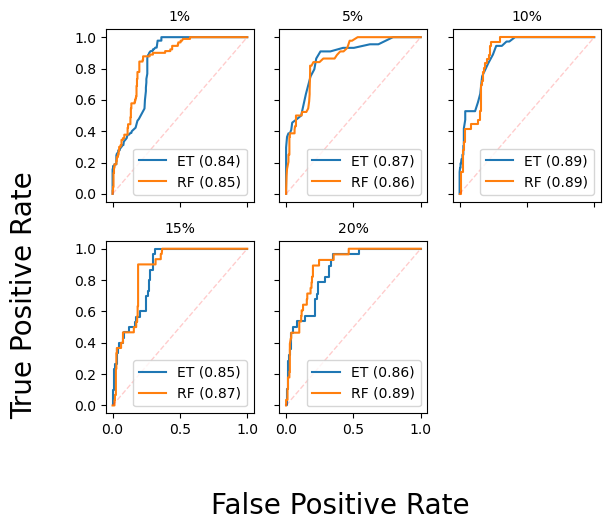

In [17]:
test_pickle = Path('./analysis/rerun_with_all_features_test.pkl')

with open(test_pickle, 'rb') as f:
    test_features_at_percentage = pickle.load(f)

# Experiment for REVIEWER 1
# keep only where mzn == "2DPacking.mzn" or "wwtpp.mzn"
test_features_at_percentage = {k: v[v['mzn'].isin(['2DPacking.mzn', 'wwtpp.mzn'])] for k, v in test_features_at_percentage.items()}
# add back the problems that were dropped from the training set
for percentage in test_features_at_percentage:
    test_features_at_percentage[percentage] = pd.concat([test_features_at_percentage[percentage], only_2DPacking_and_wwtpp[percentage]])

# Experiment for REVIEWER 3
# test_features_at_percentage = drop_easy_problems(test_features_at_percentage)

# Create a figure and axes with 4 subplots
fig, ax = plt.subplots(2, 3, figsize=(6, 5), sharex=True, sharey=True)

fig.subplots_adjust(hspace=0.1, wspace=0.3)
ax = ax.flatten()
scores = []

for i, percentage in enumerate([1, 5, 10, 15, 20]):
    for model in ['ET', 'RF', 'Dum']:
        scaler = scalers[(percentage, model)]
        df, _ = preprocess(test_features_at_percentage[percentage], scaler)
        df = df.drop(columns=['mzn'], axis=1)
        
        test_X, test_y = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']
        
        y_score = classifiers[(percentage, model)].predict_proba(test_X)[:, 1]
        if model != 'Dum':
            display = RocCurveDisplay.from_predictions(test_y, y_score, ax=ax[i], name=model)
            line = display.line_
            display.line_.set_label(line.get_label().replace('AUC = ', ''))
            ax[i].legend()
            ax[i].set_xlabel('')
            ax[i].set_ylabel('')

        prec, rec, score, support = precision_recall_fscore_support(test_y, classifiers[(percentage, model)].predict(test_X), average='binary', pos_label=False)
        accuracy = accuracy_score(test_y, classifiers[(percentage, model)].predict(test_X))
        balanced_accuracy = balanced_accuracy_score(test_y, classifiers[(percentage, model)].predict(test_X))
        # print(f"For {model} at {percentage}%, Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {score:.2f}")
        
        scores.append([percentage, model, accuracy, balanced_accuracy, prec, rec, score])

    ax[i].set_title(f"{percentage}%", fontsize=10)
    ax[i].plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', alpha=.2)
            

fig.supxlabel('False Positive Rate', fontsize=20, y=-0.05, x=0.54)
fig.supylabel('True Positive Rate', fontsize=20, x=-0.01, y=0.4)
ax[5].set_axis_off()
fig.tight_layout()

tikzplotlib.clean_figure(fig)
#tikzplotlib.save("roc_curves.tex", axis_width="0.36\\textwidth", axis_height="0.36\\textwidth")

In [12]:
score_df = pd.DataFrame(scores, columns=['Percentage', 'Model', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1 score'])
score_df = score_df.set_index(['Percentage', 'Model']).unstack()
score_df.index = score_df.index.astype(str)+"%"
score_df.round(2).style.highlight_max(axis=1, props="font-weight:bold;", subset=pd.IndexSlice[:, ['F1 score']])

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [ ]:
(score_df.drop(columns=["Accuracy"]).round(2)
    .style.format_index(escape='latex')
    .format(precision=2)
    .highlight_max(axis=1, props="textbf:--rwrap;", subset=pd.IndexSlice[:, ['F1 score']])
    .to_latex(
        "performance-table.tex",
        hrules=True,
        multicol_align='c',
        caption="Performance measures for each model at varying \% of TL.",
        label="tab:performance-measures",
        position_float="centering")
)

In [ ]:
fig = plt.figure(figsize=(100, 15))
plot_tree(classifiers[(5, 'DT')], max_depth=6, feature_names=df.columns, class_names=['unsolved', 'solved'], filled=True, fontsize=8, proportion=True);

In [ ]:
def get_importances(percentage, model, classifiers, test_X, test_y):
    model = classifiers[(percentage, model)]
    result = permutation_importance(model, test_X, test_y, n_repeats=10, random_state=42, n_jobs=-1)
    # model = classifiers[(percentage, model)]
    # importance = model.feature_importances_
    # std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    # return pd.DataFrame({'mean': importance, 'std': std}, index=model.feature_names_in_)
    return pd.DataFrame({'mean': result.importances_mean, 'std': result.importances_std}, index=model.feature_names_in_)

fig, ax = plt.subplots(5, 1, figsize=(10, 20), sharex=False, sharey=False)
fig.subplots_adjust(hspace=1, wspace=0.3)
ax = ax.flatten()

for i, percentage in enumerate([1, 5, 10, 15, 20]):
    # percentage = 5
    df, _ = preprocess(test_features_at_percentage[percentage], scaler)
    df = df.drop(columns=['mzn'], axis=1)
    test_X, test_y = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']
    importance = get_importances(percentage, 'RF', classifiers, test_X, test_y).sort_values(by='mean', ascending=False)
    ax[i] = importance['mean'].plot.bar(yerr=importance['std'], capsize=2, ax=ax[i], title=f"{percentage}%", rot=90)

# plt.barh(m.index, m['importance'], xerr=s['std'], capsize=2)
# rf_importances = pd.DataFrame([get_importances(x, c, classifiers) for x in [5, 10, 15, 20] for c in ['RF']], index=[5, 10, 15, 20])
# et_importances = pd.DataFrame([get_importances(x, c, classifiers) for x in [5, 10, 15, 20] for c in ['ET']], index=[5, 10, 15, 20])

In [ ]:
importance = get_importances(percentage, 'ET', classifiers, test_X, test_y).sort_values(by='mean', ascending=False)
importance['mean'].plot.bar(yerr=importance['std'], capsize=2)

In [ ]:
all_features = train_features_at_percentage #{i: pd.concat([train_features_at_percentage[i], test_features_at_percentage[i]]) for i in range(1, len(train_features_at_percentage) + 1)}

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict


def get_rankings_for_percentages(percentage, depth, model='RF'):
    df, _ = preprocess(all_features[percentage], scaler)
    df = df.drop(columns=['mzn'], axis=1)
    X, y = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']

    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    corr = spearmanr(X).correlation

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    # dendro = hierarchy.dendrogram(
    #     dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
    # )
    # dendro_idx = np.arange(0, len(dendro["ivl"]))

    # ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    # ax2.set_xticks(dendro_idx)
    # ax2.set_yticks(dendro_idx)
    # ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
    # ax2.set_yticklabels(dendro["ivl"])
    # _ = fig.tight_layout()

    df, _ = preprocess(train_features_at_percentage[percentage], scaler)
    df = df.drop(columns=['mzn'], axis=1)
    X_train, y_train = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']

    df, _ = preprocess(test_features_at_percentage[percentage], scaler)
    df = df.drop(columns=['mzn'], axis=1)
    X_test, y_test = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']

    cluster_ids = hierarchy.fcluster(dist_linkage, depth, criterion="distance")

    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    selected_features_names = X.columns[selected_features]

    X_train_sel = X_train[selected_features_names]
    X_test_sel = X_test[selected_features_names]

    clf_sel = RandomForestClassifier(n_estimators=100, random_state=42) if model == 'RF' else ExtraTreesClassifier(n_estimators=100, random_state=42)
    clf_sel.fit(X_train_sel, y_train)
    _, _, f1, _ = precision_recall_fscore_support(y_test, clf_sel.predict(X_test_sel), average='binary', pos_label=False)
    # print(
    #     "Baseline f1 on test data with features removed:"
    #     # f" {clf_sel.score(X_test_sel, y_test):.2}"
    #     f" {f1:.2}"
    # )

    def plot_permutation_importance(clf, X, y, ax, selected_features, cluster_id_to_feature_ids, all_columns):
        result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
        perm_sorted_idx = result.importances_mean.argsort()
        labels = []
        for i in np.array(selected_features)[perm_sorted_idx]:
            for k, v in cluster_id_to_feature_ids.items():
                if i in v:
                    main_feature = all_columns[i]
                    all_features = all_columns[v].difference([main_feature])
                    labels.append(str(main_feature) + " " + str(list(all_features)).replace('[', '(').replace(']', ')'))

        ax.boxplot(
            result.importances[perm_sorted_idx].T,
            vert=False,
            labels=X.columns[perm_sorted_idx],
            # labels=labels,
        )
        ax.axvline(x=0, color="k", linestyle="--")
        return ax, list(reversed(labels))

    fig, ax = plt.subplots(figsize=(17, 6))
    _, labels = plot_permutation_importance(clf_sel, X_test_sel, y_test, ax, selected_features, cluster_id_to_feature_ids, X.columns)
    # ax.set_title("Permutation Importances on selected subset of features\n(test set)")
    # ax.set_xlabel("Decrease in accuracy score")
    # ax.figure.tight_layout()
    # plt.show()
    return labels

importance_df = []
for perc in [1, 5, 10, 15, 20]:
    print(f"Percentage: {perc}")
    labels_with_groups_rf = get_rankings_for_percentages(perc, 1.1, model='RF')
    just_labels_rf = [x.split()[0] for x in labels_with_groups_rf[:5]]  # Get the first 5 labels
    labels_with_groups_et = get_rankings_for_percentages(perc, 1.1, model='ET')
    just_labels_et = [x.split()[0] for x in labels_with_groups_et[:5]]  # Get the first 5 labels
    labels = just_labels_rf + just_labels_et
    importance_df.append(labels)
    print(labels)
importance_df = pd.DataFrame(importance_df, index=['1%', '5%', '10%', '15%', '20%'], columns=pd.MultiIndex.from_product([['RF', 'ET'], range(1, 6)]))
importance_df.index.name = 'Percentage'
importance_df.columns.name
# importance_df.fillna('')

In [ ]:
importance_df.columns.names = ['Model', 'Rank']
(importance_df['RF']
        .replace('intVars', 'int_vars')
        .replace('bin', 'bin_clauses')
        .style
        .format_index(escape='latex')
        .format("\\texttt{{{}}}", escape='latex')
        .to_latex("importance-table.tex",
                hrules=True,
                multicol_align='c',
                caption="Permutation importance rankings for RF at varying \% of TL. Rank 1 is the most important feature, rank 5 is less important.",
                label="tab:importance-measures",
                position_float="centering",
        )
)
importance_df['RF'].replace('intVars', 'int_vars').replace('bin', 'bin_clauses')

In [ ]:
print(", ".join([f"\\texttt{{{x}}}" for x in {l.split()[0]: l.replace(')', '').replace('(', '').replace("'", "").replace(",", "").replace('_', '\_').split()[1:] for l in labels_with_groups_rf}['bin']]))

In [ ]:
n_total = np.array([train_features_at_percentage[i].shape[0] for i in range(1, len(train_features_at_percentage) + 1)])
n_solved = np.array([train_features_at_percentage[i]['solved_within_time_limit'].sum() for i in range(1, len(train_features_at_percentage) + 1)])
n_not_solved = np.array([n_total[i] - n_solved[i] for i in range(len(n_total))])
percentage_solved = np.array([n_solved[i] / n_total[i] for i in range(len(n_total))]) * 100

x = np.arange(1, 20.5, 0.5)

fig, ax = plt.subplots(figsize=(8, 3))
stacks = ax.stackplot(x, n_not_solved, n_solved, labels=['Not solved', 'Solved'])
ax.set_title("Number of instances at varying % of TL")
ax.set_xlabel("% of TL")
ax.set_ylabel("Total Number of instances")
ax.set_ylim([0, 1400])
ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98))

# fig.legend(loc='upper right', bbox_to_anchor=(0.88, 0.88))
# fig.tight_layout()
# plt.savefig("class_balance_over_time.pgf", backend="pgf")
# tikzplotlib.clean_figure()
tikzplotlib.save("class_balance_over_time.tex", axis_width="0.9\\textwidth", axis_height="0.4\\textwidth")

In [ ]:
import glob
import enum

class ProblemType(enum.Enum):
    UNKNOWN = 0
    SAT = 1
    OPT = 2

fzn_files = list(glob.glob(f"analysis/problems_compiled/*.fzn"))
summary = []


for fzn_file in track(fzn_files, description="Counting SAT/OPT"):
    with open(fzn_file, "r") as f:
        contents = f.read()
        problem_type = None
        if "satisfy" in contents:
            problem_type = ProblemType.SAT
        elif "minimize" in contents or "maximize" in contents:
            problem_type = ProblemType.OPT
        else:
            problem_type = ProblemType.UNKNOWN
        
        summary.append({
            "Problem": fzn_file,
            "Problem Type": problem_type
        })

summary_df = pd.DataFrame(summary, dtype=str)

In [ ]:
regex_str = r'analysis/problems_compiled/.+MZN-(.+)-DZN.+\.fzn'
all_mzn = summary_df['Problem'].str.extract(regex_str, expand=False) + '.mzn'
summary_df['mzn'] = all_mzn
regex_str = r'analysis/problems_compiled/.+DZN-(.+)\.fzn'
all_dzn = summary_df['Problem'].str.extract(regex_str, expand=False) + '.dzn'
summary_df['dzn'] = all_dzn

half_percent_feautures = all_features[1]

summary_df['Past Half Percent'] = summary_df[['mzn', 'dzn']].apply(tuple, axis=1).isin(half_percent_feautures[['mzn', 'dzn']].apply(tuple, axis=1))
summary_past = summary_df[summary_df['Past Half Percent']]
summary_past

grouped_summary_df = summary_df.groupby(['Problem Type', 'Past Half Percent']).count().drop(columns=['mzn', 'dzn']).unstack()
grouped_summary_df = grouped_summary_df.rename(columns={'Problem': 'Count'}).rename(index={str(ProblemType.SAT): 'SAT', str(ProblemType.OPT): 'OPT', ProblemType.UNKNOWN: 'Unknown'}).droplevel(0, axis=1).rename(columns={True: "$\ge$0.5TL\%", False: "<0.5TL\%"})
grouped_summary_df['Total'] = grouped_summary_df.sum(axis=1)
cols = grouped_summary_df.columns
grouped_summary_df[[cols[2], cols[0], cols[1]]].rename_axis(None, axis=1)